# Time Series Analysis

Document is still in progress. It currently includes a mixture of a) time series visualization and b) an approach to extract alarm violations (different from what Jonas did, as far as I know).

I will tidy it up later and put the time series plot to into the templates for plots document.

In [ ]:
# Read CHARTEVENTS into Dask DataFrame (parallel DataFrame composed of many smaller Pandas DataFrames)
import dask.dataframe as dd
chartevents = dd.read_csv('./mimic/CHARTEVENTS.csv', dtype={
    'ICUSTAY_ID': 'float64','CGID': 'float64','ERROR': 'float64','STOPPED': 'object','VALUE': 'object','WARNING': 'float64','RESULTSTATUS': 'object'})
chartevents.head()

In [ ]:
# Select only the first partition of the chartevents Dask DataFrame (to save computation time when testing the plot) 
import pandas as pd
chartevents_subset = pd.DataFrame(chartevents.get_partition(1).compute())
display(chartevents_subset)

In [ ]:
# Create subset for Heart Rate values and thresholds using the respective ITEMIDs
chartevents_subset_HR = chartevents_subset[(chartevents_subset["ITEMID"].isin([220045,220046,220047]))]

In [ ]:
# For testing the visualization, an ICU Stay is now selected that has enough data points for a meaningful visualization.

# Create data frame with new column EVENTCOUNT, which counts how often an ITEMID has occurred per ICUSTAY_ID.
events_per_icustay = chartevents_subset_HR.groupby(['ICUSTAY_ID','ITEMID']).size().reset_index(name='EVENTCOUNT')

# Arrange data using pivot
events_per_icustay = events_per_icustay.pivot('ICUSTAY_ID','ITEMID')

display(events_per_icustay)

In [ ]:
# Show those ICU stays where between 50 and 500 heart rate values have been recorded and ...
# ... at least 2 HIGH heart rate alarms have been set (not triggered!) and ...
# ... at least 2 LOW heart rate alarms have been set (not triggered!).
# Sort descending by the number of recorded heart rate values.
events_per_icustay[ 
    (events_per_icustay[('EVENTCOUNT', 220045)] > 50) & 
    (events_per_icustay[('EVENTCOUNT', 220045)] < 500) & 
    (events_per_icustay[('EVENTCOUNT', 220046)] > 2) & 
    (events_per_icustay[('EVENTCOUNT', 220047)] > 2) 
    ].sort_values(by=('EVENTCOUNT', 220045), ascending=False)

In [ ]:
# ICUSTAY_ID "227109.0" is selected for further visualization.
selected_icustay = chartevents_subset_HR[(chartevents_subset_HR["ICUSTAY_ID"] == 227109.0)].copy()
display(selected_icustay)

In [ ]:
# Add new column with ITEMID_LABEL, which can be used for the legend of the plot.
import numpy as np
selected_icustay['ITEMID_LABEL'] = np.nan
selected_icustay['ITEMID_LABEL'] = np.where((selected_icustay['ITEMID'] == 220045) & (selected_icustay['ITEMID_LABEL'] != np.nan), "Heart Rate (bpm)", selected_icustay['ITEMID_LABEL'])
selected_icustay['ITEMID_LABEL'] = np.where((selected_icustay['ITEMID'] == 220046) & (selected_icustay['ITEMID_LABEL'] != np.nan), "Heart rate Alarm - High (bpm)", selected_icustay['ITEMID_LABEL'])
selected_icustay['ITEMID_LABEL'] = np.where((selected_icustay['ITEMID'] == 220047) & (selected_icustay['ITEMID_LABEL'] != np.nan), "Heart rate Alarm - Low (bpm)", selected_icustay['ITEMID_LABEL'])
display(selected_icustay)

# Convert CHARTTIME to datetime
selected_icustay['CHARTTIME'] = pd.to_datetime(selected_icustay['CHARTTIME'])

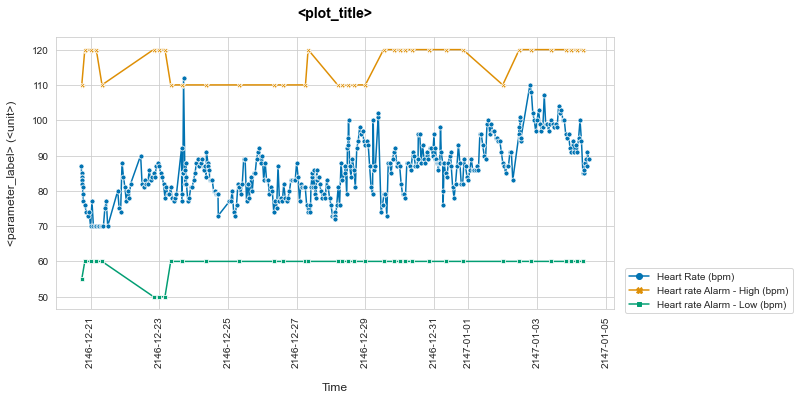

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set variables
title = "<plot_title>"
xlabel = "Time"
ylabel = "<parameter_label> (<unit>)"
plotdata = selected_icustay
xvalue = "CHARTTIME"
yvalue = "VALUENUM"
huevalue = "ITEMID_LABEL"

# Config figure
sns.set_style("whitegrid")
fig, ax = plt.subplots(
    figsize = (10, 5), 
    dpi = 72 # e.g. 72 for screen, 300 for print
    )
ax = sns.lineplot(
    data = plotdata, 
    x = xvalue,
    y = yvalue, 
    hue = huevalue,
    style= huevalue,
    markers = True,
    markersize = 5,
    dashes = False,
    palette = [sns.color_palette("colorblind")[0],sns.color_palette("colorblind")[1],sns.color_palette("colorblind")[2]]
    )
plt.legend(title = None, bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
ax.set_title(title, fontweight='bold', color= 'black', fontsize=14, y=1.05)
ax.set_xlabel(xlabel, fontsize=12, labelpad=15)
ax.set_ylabel(ylabel, fontsize=12, labelpad=15)
plt.xticks(rotation = 90)

# Plot figure
plt.show(fig)

## Identify Alarm Violations

In [18]:
# Create a time-indexed data frame that allows to identify intersection, i.e. triggered alarms a.k.a alarm violations
 
# Firstly, create time-indexed pandas seriesDas
value_series = selected_icustay[(selected_icustay["ITEMID"] == 220045)][['CHARTTIME','VALUENUM']].set_index('CHARTTIME').squeeze().rename("VALUE")
threshold_high_series = selected_icustay[(selected_icustay["ITEMID"] == 220046)][['CHARTTIME','VALUENUM']].set_index('CHARTTIME').squeeze().rename("THRESHOLD_HIGH")
threshold_low_series = selected_icustay[(selected_icustay["ITEMID"] == 220047)][['CHARTTIME','VALUENUM']].set_index('CHARTTIME').squeeze().rename("THRESHOLD_LOW")
# Secondly, merge series to data frame using pd.concat
timeseries = pd.concat([value_series, threshold_high_series, threshold_low_series], axis=1).copy()
display(timeseries)

,VALUE,THRESHOLD_HIGH,THRESHOLD_LOW
CHARTTIME,,,
2146-12-20 17:35:00,87.0,NaN,NaN
2146-12-20 17:42:00,85.0,NaN,NaN
2146-12-20 17:45:00,84.0,NaN,NaN
2146-12-20 17:52:00,84.0,110.0,55.0
2146-12-20 18:00:00,83.0,NaN,NaN
...,...,...,...
2147-01-04 09:07:00,88.0,NaN,NaN
2147-01-04 10:00:00,89.0,NaN,NaN
2147-01-04 11:00:00,87.0,NaN,NaN


In [19]:
# Interpolate missing values by using the last available value
# If there is no previous value available, no value will be inserted during the interpolation. The value remains NaN. This is to be expected for alarm limits in the beginning of the time series, since they are likely to be set after the first vital sign values have been recorded.
timeseries['THRESHOLD_HIGH'] = timeseries['THRESHOLD_HIGH'].interpolate('pad')
timeseries['THRESHOLD_LOW'] = timeseries['THRESHOLD_LOW'].interpolate('pad')
# I am not sure if we should interpolate the values of the vital parameter. I think rather not, since these may have changed since the last recorded measurement (as opposed to the alarm limits for which changes are always recorded).
# timeseries['VALUE'] = timeseries['VALUE'].interpolate('pad') 
display(timeseries)

,VALUE,THRESHOLD_HIGH,THRESHOLD_LOW
CHARTTIME,,,
2146-12-20 17:35:00,87.0,NaN,NaN
2146-12-20 17:42:00,85.0,NaN,NaN
2146-12-20 17:45:00,84.0,NaN,NaN
2146-12-20 17:52:00,84.0,110.0,55.0
2146-12-20 18:00:00,83.0,110.0,55.0
...,...,...,...
2147-01-04 09:07:00,88.0,120.0,60.0
2147-01-04 10:00:00,89.0,120.0,60.0
2147-01-04 11:00:00,87.0,120.0,60.0


In [20]:
# Add columns containing the differences between the measured value and the currently valid threshold 
timeseries['DIF_VALUE_HIGH'] = timeseries.VALUE - timeseries.THRESHOLD_HIGH
timeseries['DIF_VALUE_LOW'] = timeseries.VALUE - timeseries.THRESHOLD_LOW
display(timeseries)

,VALUE,THRESHOLD_HIGH,THRESHOLD_LOW,DIF_VALUE_HIGH,DIF_VALUE_LOW
CHARTTIME,,,,,
2146-12-20 17:35:00,87.0,NaN,NaN,NaN,NaN
2146-12-20 17:42:00,85.0,NaN,NaN,NaN,NaN
2146-12-20 17:45:00,84.0,NaN,NaN,NaN,NaN
2146-12-20 17:52:00,84.0,110.0,55.0,-26.0,29.0
2146-12-20 18:00:00,83.0,110.0,55.0,-27.0,28.0
...,...,...,...,...,...
2147-01-04 09:07:00,88.0,120.0,60.0,-32.0,28.0
2147-01-04 10:00:00,89.0,120.0,60.0,-31.0,29.0
2147-01-04 11:00:00,87.0,120.0,60.0,-33.0,27.0


In [21]:
# Identify triggered alarms (a.k.a. alarm violations) for threshold of type HIGH
alarm_too_high = timeseries[(timeseries["DIF_VALUE_HIGH"] >= 0)][['VALUE','THRESHOLD_HIGH','DIF_VALUE_HIGH']]
alarm_too_high

,VALUE,THRESHOLD_HIGH,DIF_VALUE_HIGH
CHARTTIME,,,
2146-12-23 17:00:00,112.0,110.0,2.0


In [22]:
# Identify triggered alarms (a.k.a. alarm violations) for threshold of type LOW
alarm_too_low = timeseries[(timeseries["DIF_VALUE_LOW"] <= 0)][['VALUE','THRESHOLD_LOW','DIF_VALUE_LOW']]
alarm_too_low

,VALUE,THRESHOLD_LOW,DIF_VALUE_LOW
CHARTTIME,,,


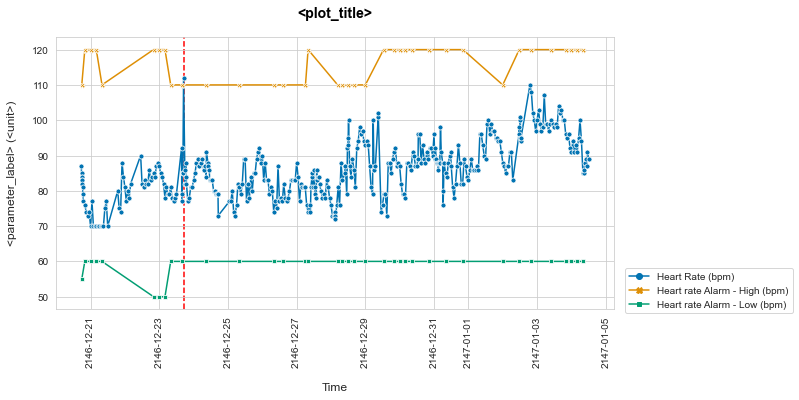

In [23]:
# Same plot as above apart from one line:
# plt.axvline(alarm_too_high.index)
# which allows to indicate the identified alarm in the plot.

import seaborn as sns
import matplotlib.pyplot as plt

# Set variables
title = "<plot_title>"
xlabel = "Time"
ylabel = "<parameter_label> (<unit>)"
plotdata = selected_icustay
xvalue = "CHARTTIME"
yvalue = "VALUENUM"
huevalue = "ITEMID_LABEL"

# Config figure
sns.set_style("whitegrid")
fig, ax = plt.subplots(
    figsize = (10, 5), 
    dpi = 72 # e.g. 72 for screen, 300 for print
    )
ax = sns.lineplot(
    data = plotdata, 
    x = xvalue,
    y = yvalue, 
    hue = huevalue,
    style= huevalue,
    markers = True,
    markersize = 5,
    dashes = False,
    palette = [sns.color_palette("colorblind")[0],sns.color_palette("colorblind")[1],sns.color_palette("colorblind")[2]]
    )
plt.legend(title = None, bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
ax.set_title(title, fontweight='bold', color= 'black', fontsize=14, y=1.05)
ax.set_xlabel(xlabel, fontsize=12, labelpad=15)
ax.set_ylabel(ylabel, fontsize=12, labelpad=15)
plt.xticks(rotation = 90)
plt.axvline(alarm_too_high.index, linestyle='dashed', color='red', zorder=0)

# Plot figure
plt.show(fig)